/var/folders/k0/t2wwzh8n4ng5pxbn25wngqyw0000gn/T/ipykernel_2609/367668676.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_to_train = imageio.imread("/users/iamns45/Downloads/CV-2/Question4/images/image12.jpg")
/var/folders/k0/t2wwzh8n4ng5pxbn25wngqyw0000gn/T/ipykernel_2609/367668676.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_to_be_queried = imageio.imread("/users/iamns45/Downloads/CV-2/Question4/images/image11.jpg")


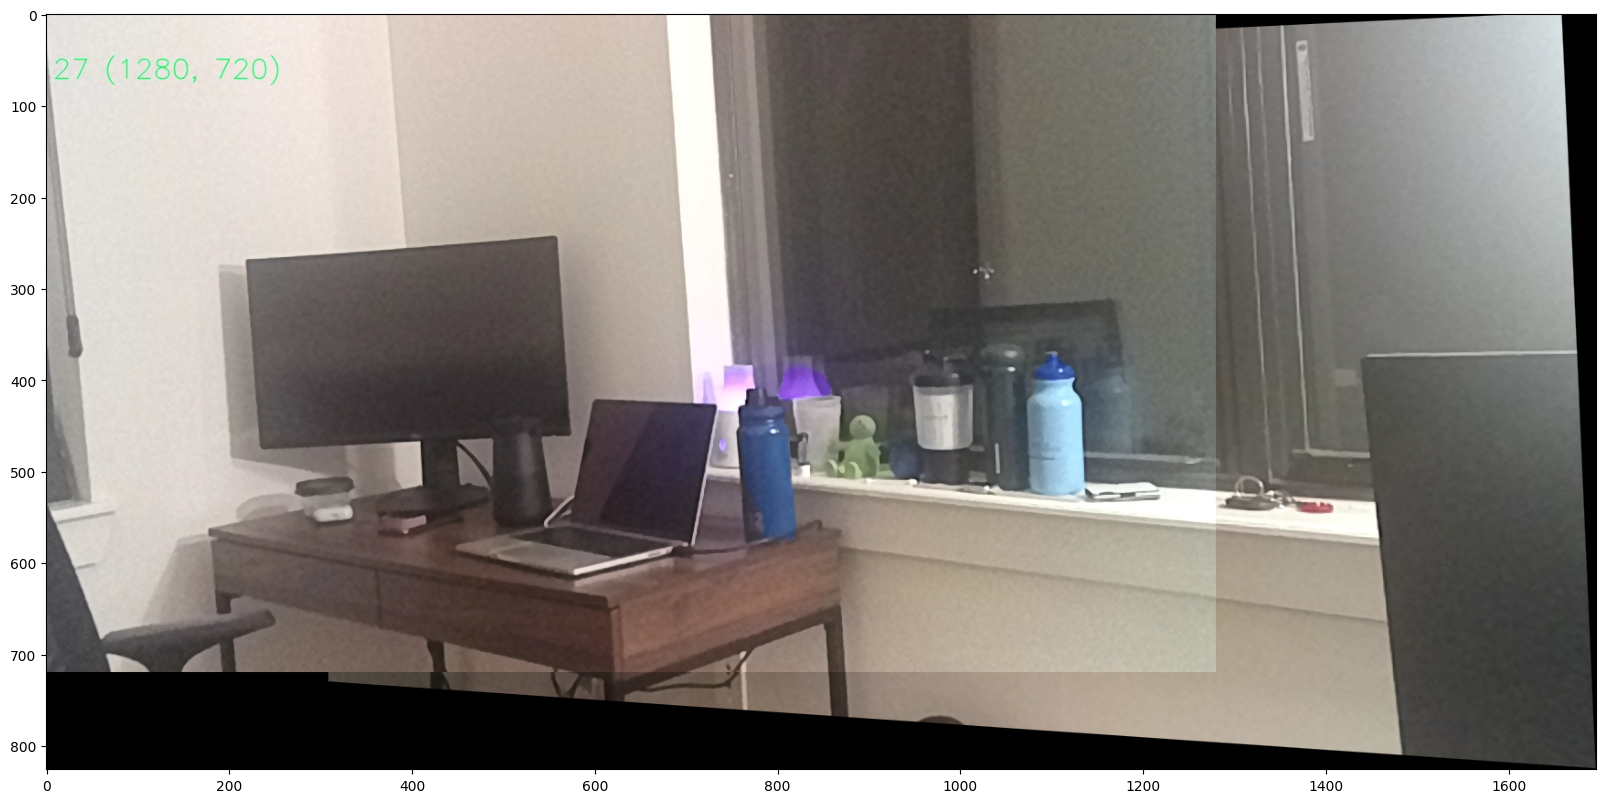

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils

cv2.ocl.setUseOpenCL(False)

def Main_Ponts_Func(image):  
    descriptor = cv2.SIFT_create()
    kps, features = descriptor.detectAndCompute(image, None)
    return (kps, features)
    
def Match_The_Key_Points_Func(features_train, features_query, ratio):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = False)
    raw_match = bf.knnMatch(features_train, features_query, 2)
    matches = []
    for m, n in raw_match:
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches    

def Find_Homography(kps_train, kps_query, matches, reprojThresh):
    kpsA = np.float32([kp.pt for kp in kps_train])
    kpsB = np.float32([kp.pt for kp in kps_query])
    if len(matches) > 4:
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        (Homography, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)    
        return(matches, Homography, status)
    else:
        return None

def Transform_To_Gray_Scale_Func(result):
    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)
    result = result[y:y + h, x:x + w]  
    return result

img_to_train = imageio.imread("/users/iamns45/Downloads/CV-2/Question4/images/image12.jpg") 
img_to_be_queried = imageio.imread("/users/iamns45/Downloads/CV-2/Question4/images/image11.jpg") 
gray_img_to_train = cv2.cvtColor(img_to_train, cv2.COLOR_RGB2GRAY)
gray_img_to_be_queried = cv2.cvtColor(img_to_be_queried, cv2.COLOR_RGB2GRAY)
kps_train, features_train = Main_Ponts_Func(gray_img_to_train) #kps and features of 1
kps_query, features_query = Main_Ponts_Func(gray_img_to_be_queried) #kps and features of 2
matches = Match_The_Key_Points_Func(features_train, features_query, 0.75)
temp_img = cv2.drawMatches(img_to_train, kps_train, img_to_be_queried, kps_query, np.random.choice(matches,100), None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
M = Find_Homography(kps_train, kps_query, matches, 4)
matches, homography, status = M
width = img_to_train.shape[1] + img_to_be_queried.shape[1]
height = img_to_train.shape[0] + img_to_be_queried.shape[0]
result = cv2.warpPerspective(img_to_train, homography, (width, height))
result[0:img_to_be_queried.shape[0], 0:img_to_be_queried.shape[1]] = img_to_be_queried
result = Transform_To_Gray_Scale_Func(result)
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()

